# Target counting using Euler integration

This technique is due to Baryshnikov and Ghrist, and was further explored by Pianini *et alia* who discovered it had more complex error behaviour than anticipated.

In [1]:
from copy import deepcopy
from itertools import combinations

from sensorplayground import SensorPlayground, SimpleSensor, TargetCount, drawField, zipboth
from simplicial import SimplicialComplex, SimplicialFunction, InferredSFRepresentation, Embedding, EulerIntegrator, TriangularLattice, TriangularLatticeEmbedding
from simplicial.drawing import drawComplex, drawEulerIntegral

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt
plt.style.use(['default', 'display.mplstyle'])

## Building the model of overhearing behaviour

The overhearing structure is a simplicial complex with a basis given by the sensors. If two sensors $s_1$ and $s_2$ could observe the same target, meaning that they have overlapping sensor fields, we add a 1-simplex $[s_1, s_2]$ to the complex. Similarly we add a 2-simplex $[s_1, s_2, s_3]$ if there is a third sensor $s_3$ whose sensor field overlaps with those of both $s_1$ and $s_2$, and so on for higher simplices.

We then define a metric over this structure that assignes a count to each sensor of the number of targets it sees, and extends this function to higher simplices by taking the minumum of a simplex' faces

In [2]:
class FaceMin(SimplicialFunction):
    '''A simplicial function that assigns to a simplex the minimum of
    the values assigned to its faces. The values assigned to 0-simplices
    must be set explicitly. By constructionthis is a valid metric
    for Euler integration.

    :param c: the complex'''

    @staticmethod
    def minimumValueOfFaces(sf, c, s):
        '''Return the minimum of the values assigned face of the given simplex.

        :param sf: the function (self)
        :param c: the complex
        :param s: the simplex
        :returns: the value'''
        return min([sf[f] for f in c.faces(s)])


    # We use an inferred representation to let us set explicit values
    # for simplices, with an inference function that fills-in the
    # values not explicitly set for other simplces.

    def __init__(self, c = None):
        rep = InferredSFRepresentation(FaceMin.minimumValueOfFaces)
        super().__init__(c, rep=rep)


    def setValueForSimplex(self, s, v):
        '''Only allow values to be set for 0-simplices (sensors).

        :param s: the 0-simplex
        :param v: the value'''
        if self.complex().orderOf(s) == 0:
            super().setValueForSimplex(s, v)
        else:
            raise ValueError(f'Trying to set the value of higher simplex {s}')

Constructing the estimator combines the overhearing complex and metric.

In [3]:
class EulerEstimator:
    '''An Euler integral overhearing structure and estimator. This
    counts targets using Euler characteristic integration over
    a simplicial function defining the "heights" of simplices,
    which must be integers.

    :param pg: the playground
    :param sf: (optional) the metric function (defaults to :class:`FaceMin`)
    '''


    def __init__(self, pg, sf = None):
        self._playground = pg
        if sf is None:
            sf = FaceMin()
        self._f = sf
        self._c = self._build()


    def _build(self):
        '''Build the overhearing structure for a set of sensors.

        The structure consists of a k-simplex for every set of (k + 1)
        sensors whose sensor fields mutually overlap. Only sensors
        having the :class:`TargetCount` modality are included

        '''

        c = SimplicialComplex()

        # extract the target counters
        ss = [s for s in self._playground if isinstance(s, TargetCount)]

        # add the basis, using the sensors' ids as simplex names
        for s in ss:
            c.addSimplex(id=s.id())

        # add higher simplices
        for k in range(1, len(ss)):
            # track now many k-simplices we create
            created = 0

            # run through all combinations of (k + 1) basis simplices
            for pb in combinations(ss, k + 1):
                pairwise = True

                # check all pairwise distances
                for (i, j) in combinations(pb, 2):
                    if not i.isOverlappingWith(j):
                        # pair is not overlapping, so can't create
                        # a k-simplex from this basis
                        pairwise = False
                        break

                # if all the pairwise distances were overlapping,
                # create the higher simplex on this basis
                if pairwise:
                    bs = [s.id() for s in pb]
                    c.addSimplexWithBasis(bs)
                    created += 1

            # if we created enough k-simplices to potentially build
            # a (k + 1)-simplex, carry on; otherwise we can't build any
            # higher simplices, and so can escape from the loop
            if created < (k + 1) + 1:
                break

        # set the overhearing structure as the complex underlying the height function
        self._f.setComplex(c)

        # return the overhearing structure
        return c


    def overhearing(self):
        '''Return the overhearing complex.

        :returns: the complex'''
        if self._c is None:
            self.rebuild()
        return self._c


    def metric(self):
        '''Return the metric function.

        :returns: the function'''
        return self._f


    def rebuild(self):
        '''Rebuild the overhearing structure. Needed if the underlying
        playground has changed.'''
        self._c = self._build()


    def setCounts(self, cs):
        '''Set the counts observed at all the sensors. If a sensor
        appears more than once in the iteration, the last value is the
        one that's assigned. The metric function is responsible
        for computing the values of non-sensor higher simplices.

        :param ss: the sensors
        :param cs: the counts

        '''

        # set the observed counts
        sf = self.metric()
        for s in cs:
            sf[s.id()] = cs[s]


    def estimateFromCounts(self, cs) -> int:
        '''Estimate the total target count from the counts observed
        at all the sensors. Any sensors not given a count are assumed
        to count zero.

        :param ss: the sensors
        :param cs: the counts
        :returns: the estimated target count'''

        # set the counts
        self.setCounts(cs)

        # integrate the Euler characteristics
        integrator = EulerIntegrator()
        count = integrator.integrate(self.overhearing(), self.metric())

        return count


    def estimateFromTargets(self, ts) -> int:
        '''Estimate the count of a collection of targets.

        The estimator computes the counts at each sensor from
        the target positions.

        One simple error measure is the fraction by which the estimate
        differs from the (known) actual number of targets.

        :param ts: the targets
        :returns: the estimated target count'''

        # compute the counts at each sensor
        cs = {}
        for s in self._playground.allSensorsWithModality(TargetCount):
            cs[s] = s.counts(ts)
        
        # compute the estimate
        return self.estimateFromCounts(cs)

The idea behind the Euler integration estimator is to compute the Euler characteristic over successive sub-complexes of the overhearing complex, filtering based on the count at each sensor.

Let's start with the situation we had before: a sensor field with two targets, one observed by one sensor and one observed by four sensors as before. The naive estimate of summing-up all the individual counts over-counts the target population.

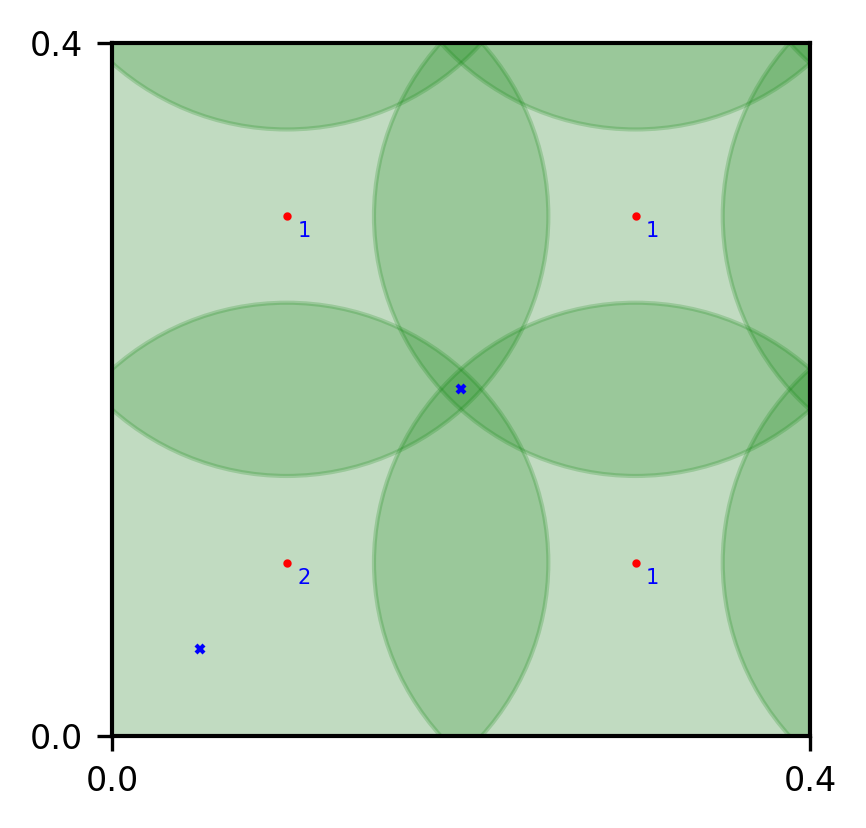

In [4]:
# placed the sensors in a 5x5 grid
grid = SensorPlayground()
d = 0.15
for i in range(5):
    for j in range(5):
        p = [0.1 + (1 / 5) * i, 0.1 + (1 / 5) * j]
        grid.addSensor(SimpleSensor(d), p)

# carefully place the targets
t1 = [0.05, 0.05]
t2 = [0.2, 0.2]

fig = plt.figure(figsize=(3, 3))
drawField(grid, ts=[t1, t2], subfieldWH=(0.4, 0.4), showCount=True)
plt.show()

In [5]:
# count the targets by asking all sensors for their count
cs = []
targets = 0
for s in grid:
    c = s.counts([t1, t2])
    cs.append(c)
    targets += c

print(f'Counting {targets} targets')

Counting 5 targets


Let's now apply the Euler integration method to the same sensors with the same individual counts and see what happens.

In [6]:
# build the overhearing structure
e = EulerEstimator(grid)

# run the estimator
targets = e.estimateFromTargets([t1, t2])

print(f'Counting {targets} targets')

Counting 2 targets


So that worked well! -- the extra topological information about overhearing resolved the overcounting of one of the targets and yielded the correct answer.

## Mis-counting

The integrator *can* mis-count, however.

### The setup

Following [Pianini 2017] we set up with sensors sitting in a triangulated grid with some edge nodes removed.

In [7]:
def offset(pos, s, off):
    '''Return a point offset from a sensor's position.

    :param pos: the embedding
    :param s: the simplex
    :param off: the offset
    :returns: the position'''
    return list(map(lambda po: po[0] + po[1], zip(pos[s], off)))

We create the lattice, place all the vertices appropriately, and then remove the ones we don't want.

In [8]:
lattice = TriangularLattice(9, 3)
pos = TriangularLatticeEmbedding(lattice, h=0.8, w=0.8)

# pre-compute positions
_ = pos.positionsOf()

# offset all simplices within the field
for i in lattice.simplicesOfOrder(0):
    pos.positionSimplex(i, offset(pos, i, (0.15, 0.1)))

In [9]:
# remove simplices for fig 1
lattice.deleteSimplices([0, 1, 2])
lattice.deleteSimplices([4, 5])
lattice.deleteSimplices([18])
lattice.deleteSimplices([24, 25])

We position simple sensors at the remaining vertices.

In [10]:
latticeSensors = SensorPlayground()
for i in lattice.simplicesOfOrder(0):
    s = SimpleSensor(0.12, id=i)
    latticeSensors.addSensor(s, (pos[i][0], pos[i][1]))

### Correct counting

We start with a "correct" counting on the lattice, using an Euler integrator.

In [11]:
correctCount = deepcopy(latticeSensors)

t1 = offset(pos, 15, (0.04, -0.07))
t2 = offset(pos, 16, (-0.04, -0.07))

In [13]:
# build the overhearing structure and extract the metric
correctCountEstimator = EulerEstimator(correctCount)
correctCountMetric = correctCountEstimator.metric()

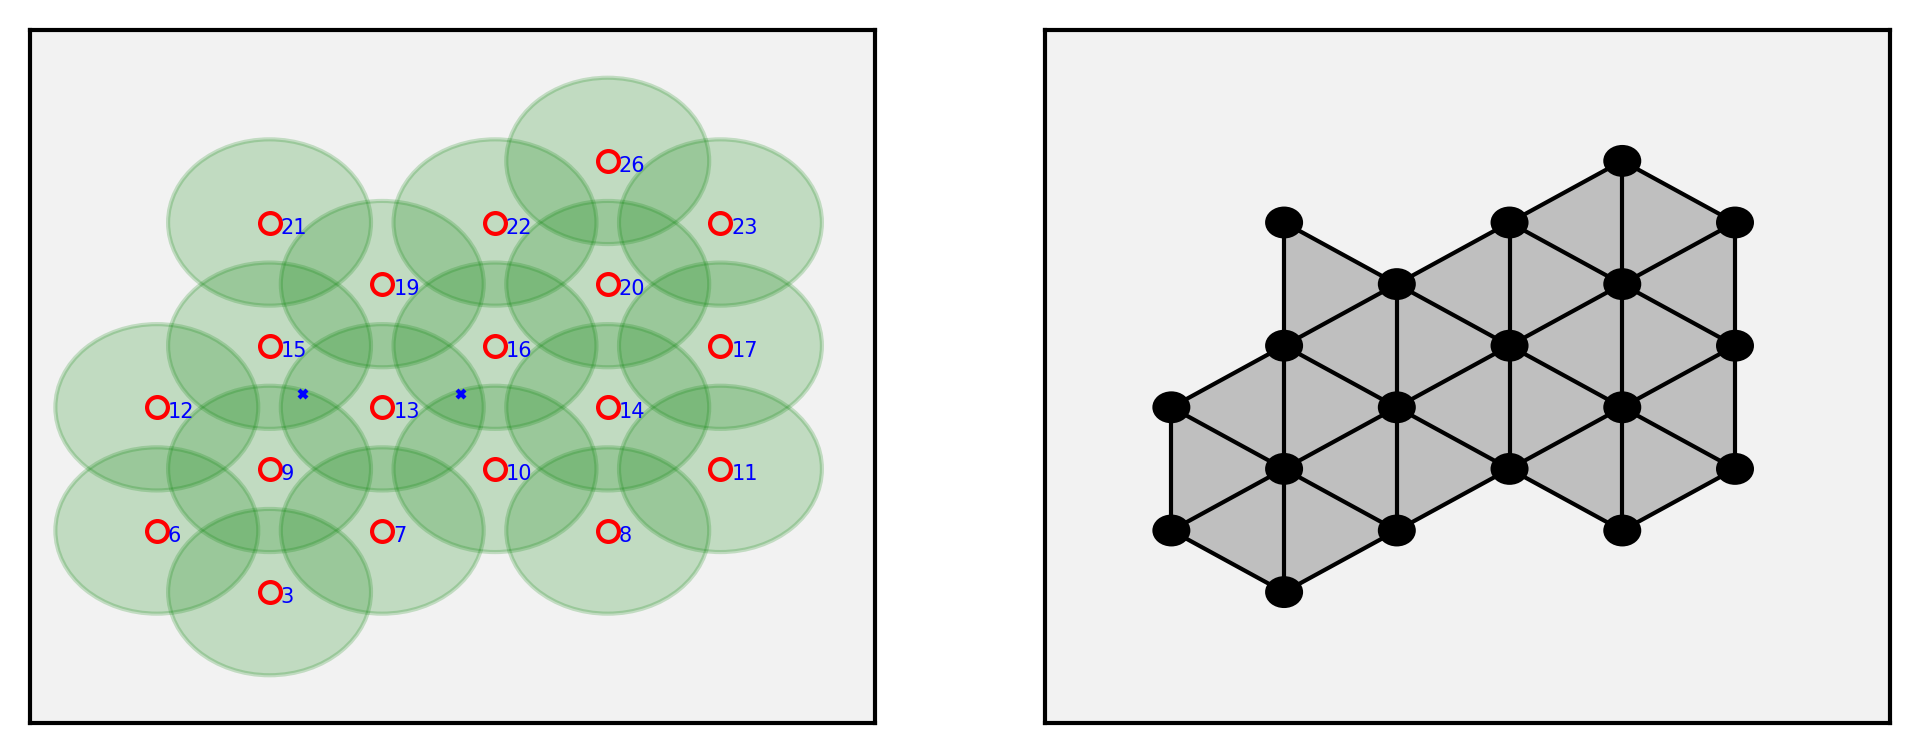

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
drawField(latticeSensors, ts=[t1, t2], ax=axs[0], showSensorLabels=True, showSensorFields=True,
          sensorSize=10, sensorFilled=False)
drawComplex(correctCountEstimator.overhearing(), pos, ax=axs[1])
plt.show()

In [15]:
correctCountTargets = correctCountEstimator.estimateFromTargets([t1, t2])

We take these observations and plot them, colour-coding the nodes and simplices according to their counts.

In [16]:
col = {}
palette = ['w', 'r', 'b']
for s in latticeSensors:
    col[s.id()] = palette[correctCountMetric[s.id()]]

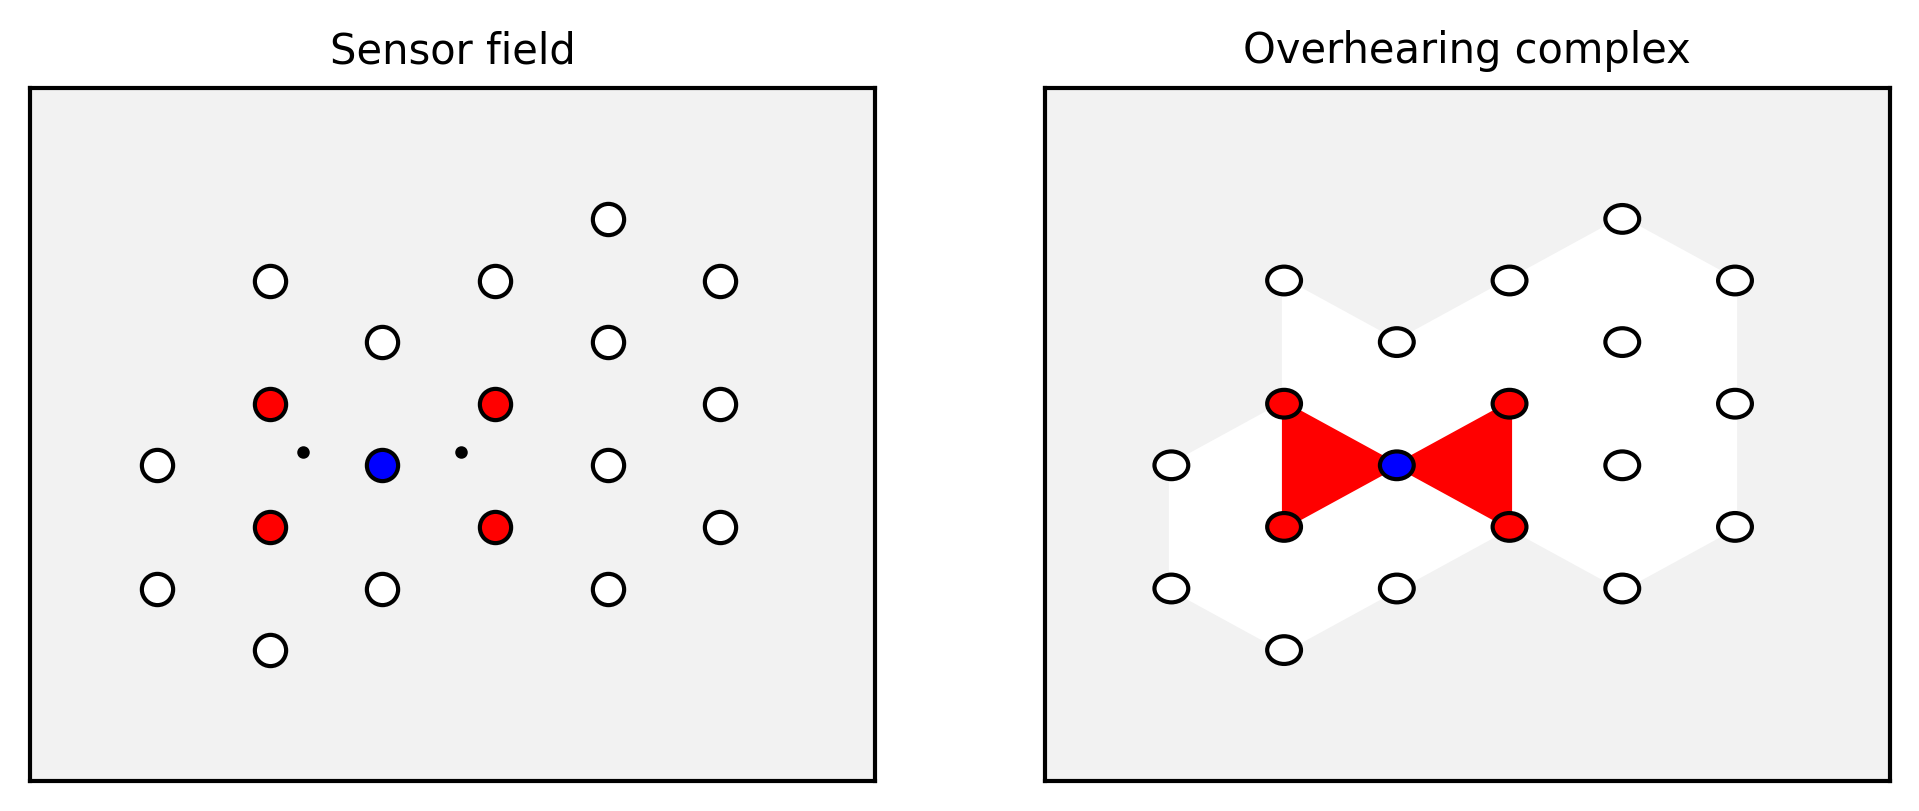

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# draw the sensor field
drawField(correctCount, ts=[t1, t2], ax=axs[0],
          showSensorLabels=False, showSensorFields=False,
          showSensors=True, sensorColour='k', sensorSize=15, sensorFilled=True, sensorFillColour=col,
          showTargets=True, targetMarker='o', targetColour='k')
axs[0].set_title('Sensor field')

# draw the overhearing complex
drawComplex(correctCountEstimator.overhearing(), pos, ax=axs[1],
            simplexColour=lambda c, s, k: palette[correctCountMetric[s]])
axs[1].set_title('Overhearing complex')

plt.show()

In [18]:
print(f'Counting {correctCountTargets} targets')

Counting 2 targets


Widely-separated targets can also be correctly counted.

In [19]:
t3 = offset(pos, 20, (0.04, -0.07))

In [20]:
correctCountWide = deepcopy(latticeSensors)
correctCountWideEstimator = EulerEstimator(correctCountWide)
correctCountWideMetric = correctCountWideEstimator.metric()
correctCountWideTargets = correctCountWideEstimator.estimateFromTargets([t1, t3])

In [21]:
col = {}
palette = ['w', 'r', 'b']
for s in latticeSensors:
    col[s.id()] = palette[correctCountWideMetric[s.id()]]

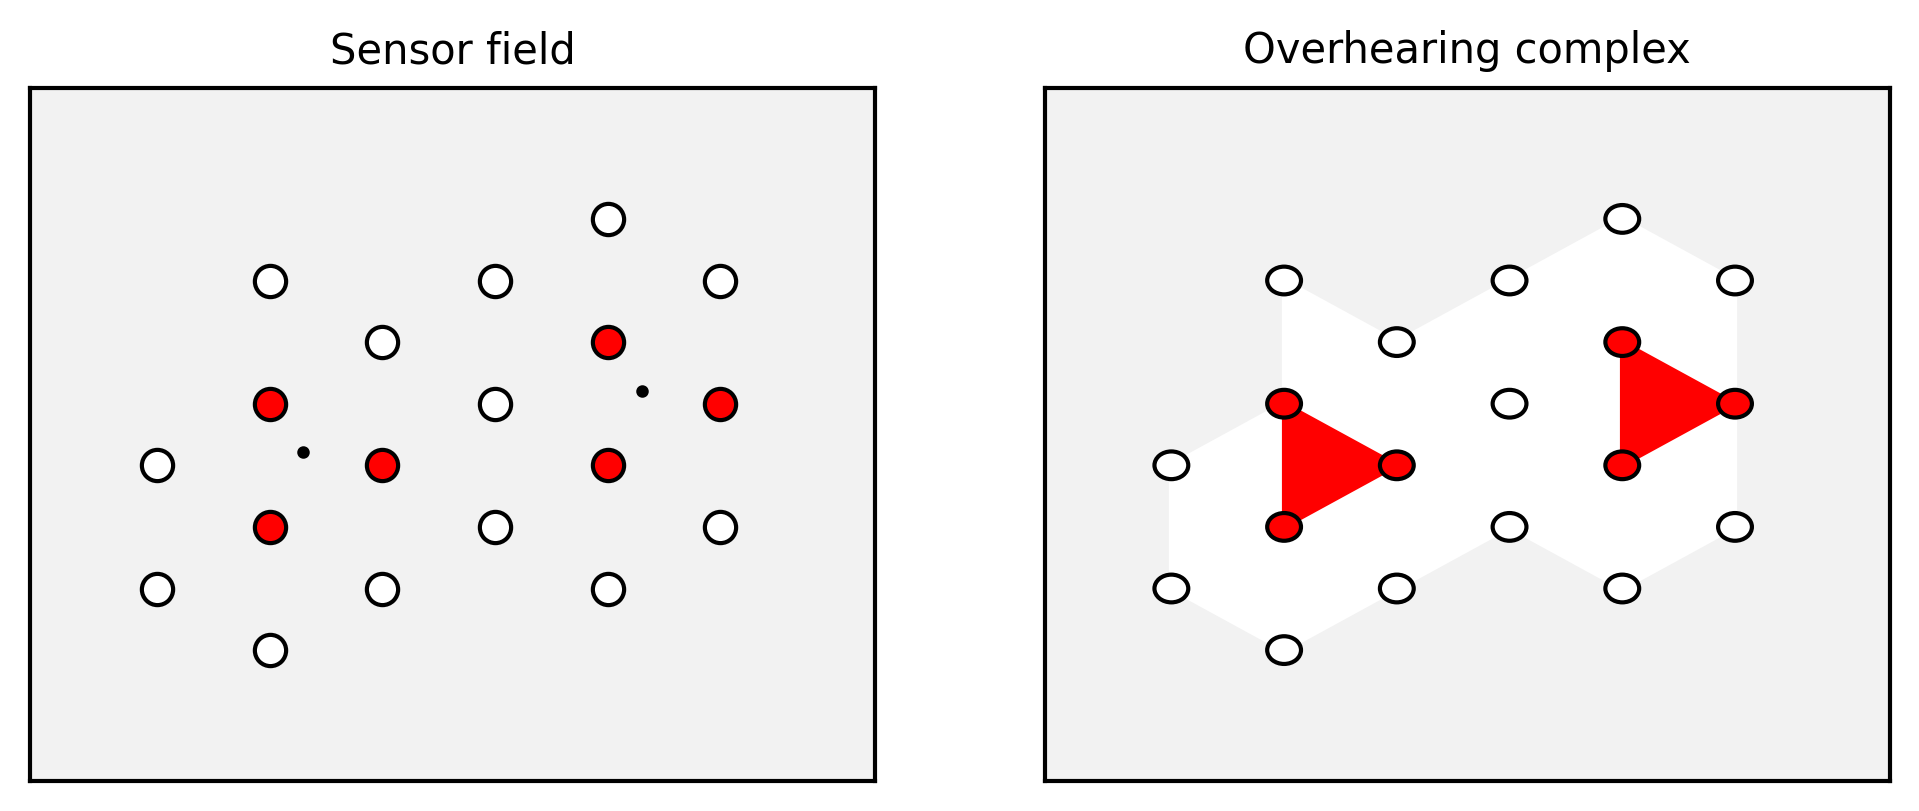

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# draw the sensor field
drawField(correctCountWide, ts=[t1, t3], ax=axs[0],
          showSensorLabels=False, showSensorFields=False,
          showSensors=True, sensorColour='k', sensorSize=15, sensorFilled=True, sensorFillColour=col,
          showTargets=True, targetMarker='o', targetColour='k')
axs[0].set_title('Sensor field')

# draw the overhearing complex
drawComplex(correctCountWideEstimator.overhearing(), pos, ax=axs[1],
            simplexColour=lambda c, s, k: palette[correctCountWideMetric[s]])
axs[1].set_title('Overhearing complex')

plt.show()

In [23]:
print(f'Counting {correctCountWideTargets} targets')

Counting 2 targets


### Incorrect count

However, suppose we spread the targets out so that there is no common sensor seeing them both, but the two sets of observing sensors are adjacent.

In [24]:
t4 = offset(pos, 20, (-0.04, -0.07))

In [25]:
incorrectCount = deepcopy(latticeSensors)
incorrectCountEstimator = EulerEstimator(incorrectCount)
incorrectCountMetric = incorrectCountEstimator.metric()
incorrectCountTargets = incorrectCountEstimator.estimateFromTargets([t1, t4])

In [26]:
col = {}
palette = ['w', 'r', 'b']
for s in latticeSensors:
    col[s.id()] = palette[incorrectCountMetric[s.id()]]

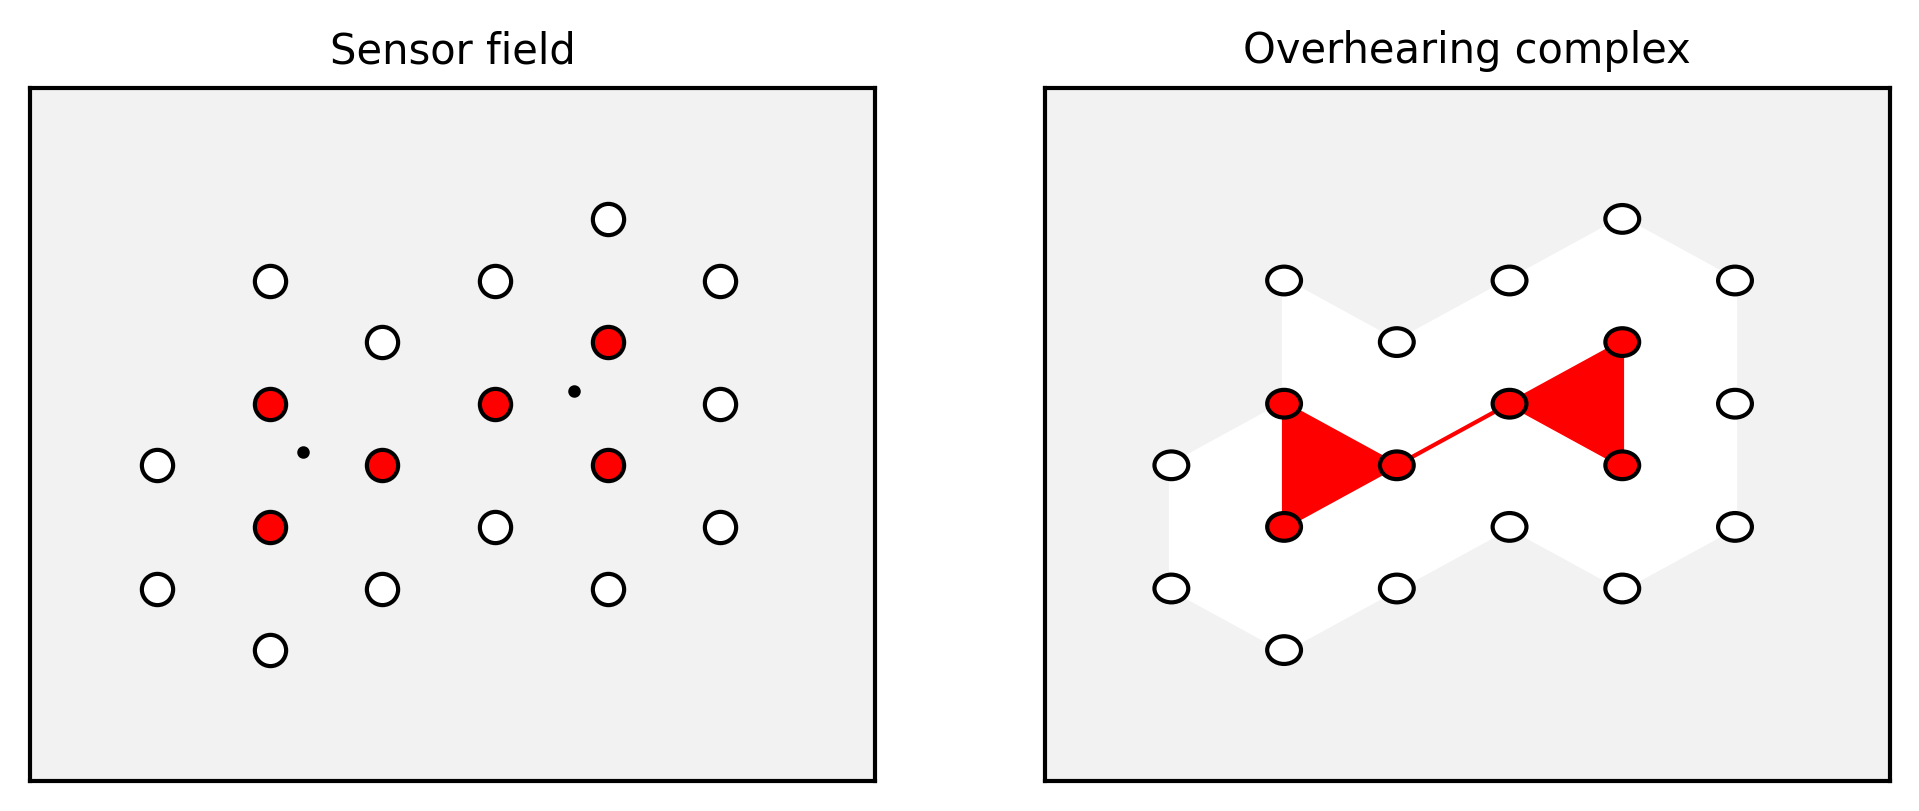

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# draw the sensor field
drawField(incorrectCount, ts=[t1, t4], ax=axs[0],
          showSensorLabels=False, showSensorFields=False,
          showSensors=True, sensorColour='k', sensorSize=15, sensorFilled=True, sensorFillColour=col,
          showTargets=True, targetMarker='o', targetColour='k')
axs[0].set_title('Sensor field')

# draw the overhearing complex
drawComplex(incorrectCountEstimator.overhearing(), pos, ax=axs[1],
            simplexColour=lambda c, s, k: palette[incorrectCountMetric[s]])
axs[1].set_title('Overhearing complex')

plt.show()

The method now under-counts the number of targets by 1.

In [28]:
print(f'Counting {incorrectCountTargets} targets')

Counting 1 targets


### Flooding the landscape

We can see how the incorrect count appears by plotting the stages of the Euler integration.

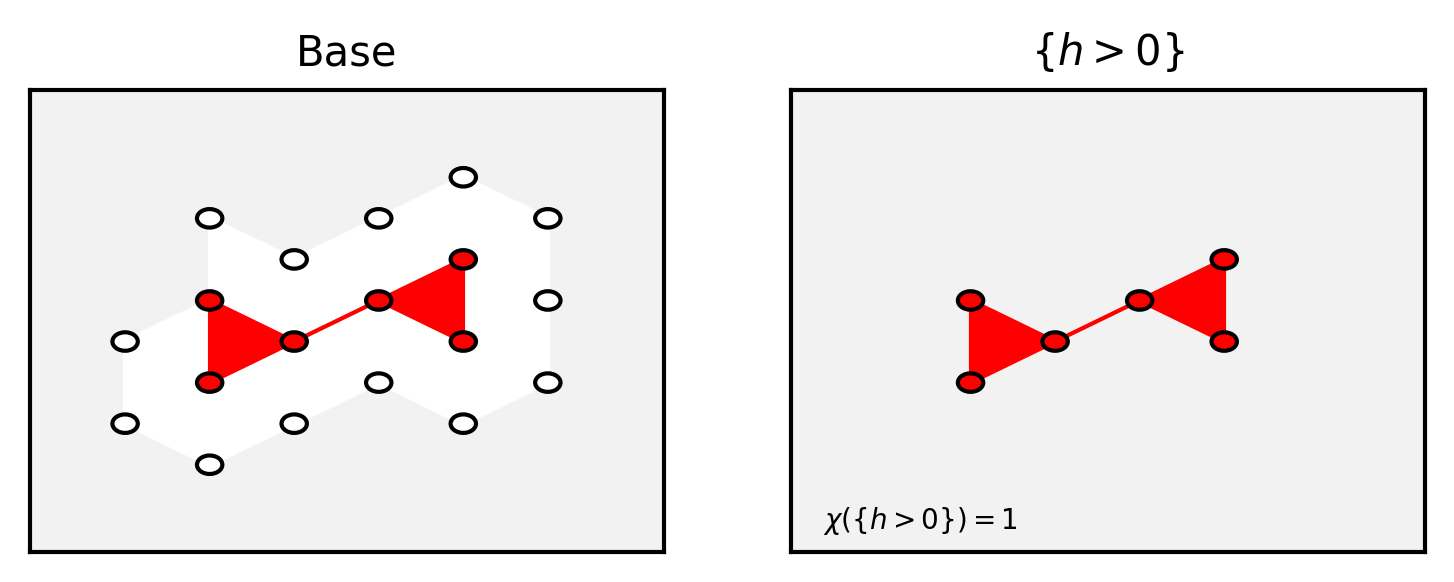

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
drawEulerIntegral(incorrectCountEstimator.overhearing(), pos, incorrectCountMetric, axs=axs,
                  showLevelSets=True, showEulerCharacteristics=True,
                  simplexColour=lambda c, s, k: palette[incorrectCountMetric[s]])
plt.show()

The level set for $\{h > 0\}$ is now connected &ndash; the two sets of observing sensors have a connecting edge, which takes the minimum of their two counts &ndash; and so has an Euler characteristic of 1. for the non-adjacent observing sets, the Euler characteristic was 2.

A more interesting example is where one sensor observes both targets. We can expand this integration to see what happens.

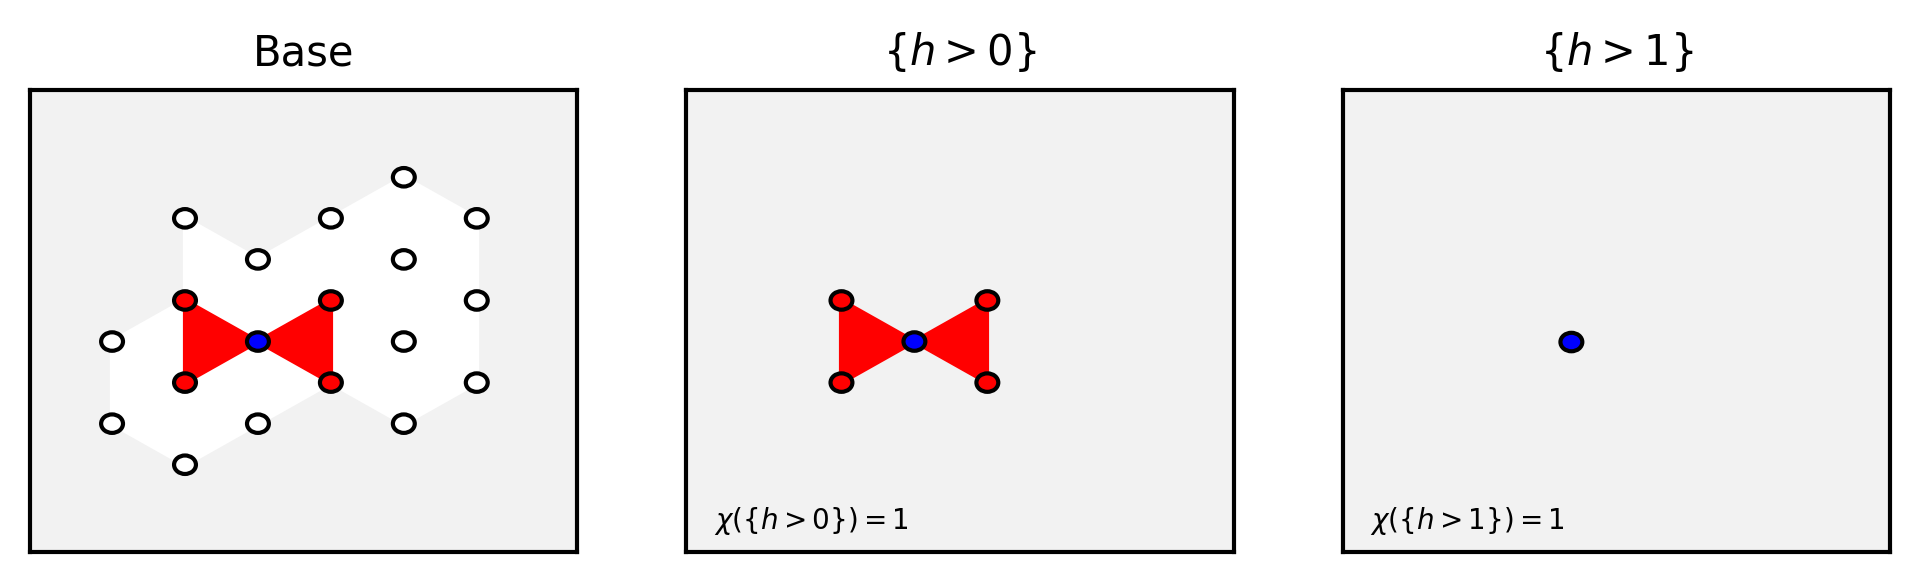

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))
drawEulerIntegral(correctCountEstimator.overhearing(), pos, correctCountMetric, axs=axs,
                  showLevelSets=True, showEulerCharacteristics=True,
                  simplexColour=lambda c, s, k: palette[correctCountMetric[s]])
plt.show()

The $\{ h > 0 \}$ level set is a single connected region that contains two targets; the $\{ h > 1 \}$ level set contains a single point. Essentially the "inner"  $\{ h > 1 \}$ level set contains the region that represents the sharing of targets within the "outer" $\{ h > 0 \}$ level set.